# CAC and LTV

In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

dbname = 'mylocaldb' 
username = 'yangyang'

con = None
con = psycopg2.connect(database = dbname, user = username)

- Find out the users/renter from facebook
- Find out users/renter not from facebook

In [2]:
# User
sql_query = """
SELECT users.id as uid, users.created_at, users.current_sign_in_at, users.provider, 
r.total_cost, r.created_at as rented_at
FROM 
users LEFT JOIN 
(SELECT rentals.renter_id, SUM(rentals.total_cost) as total_cost, 
    MIN(rentals.created_at) as created_at
FROM rentals
WHERE rentals.cancel_reason IS NULL
GROUP BY rentals.renter_id
) as r
ON users.id=r.renter_id
"""

df = pd.read_sql_query(sql_query,con)

Facebook registered=14489
Non-Facebook registered=13329


<IPython.core.display.Javascript object>


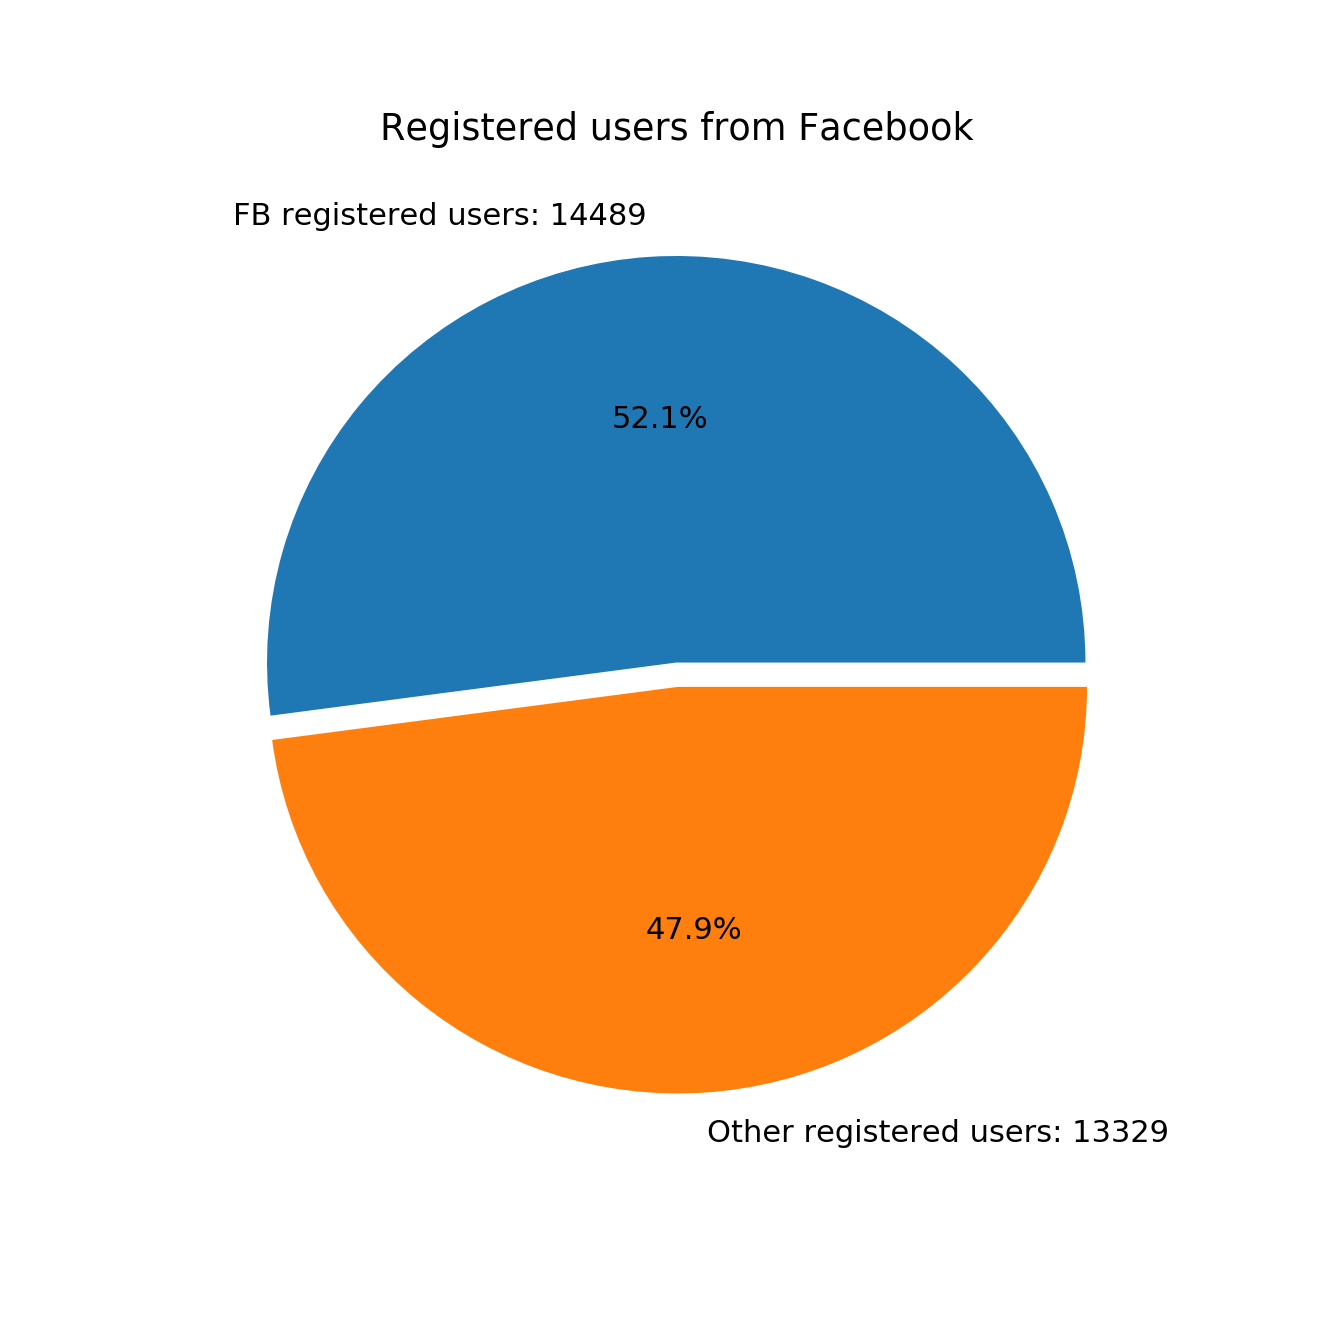

In [3]:
%matplotlib notebook
facebook_user = df[df['provider']=='facebook']
nonfacebook_user = df[df['provider'].isnull()]
print('Facebook registered={}'.format(len(facebook_user)))
print('Non-Facebook registered={}'.format(len(nonfacebook_user)))
plt.figure(figsize=(6,6))
plt.pie([len(facebook_user),len(nonfacebook_user)],
        explode=(0.01,0.05),autopct='%1.1f%%',
       labels=['FB registered users: {}'.format(len(facebook_user)),
               'Other registered users: {}'.format(len(nonfacebook_user))])
plt.title('Registered users from Facebook')

In [8]:
sum(renter_mask)

773

<IPython.core.display.Javascript object>


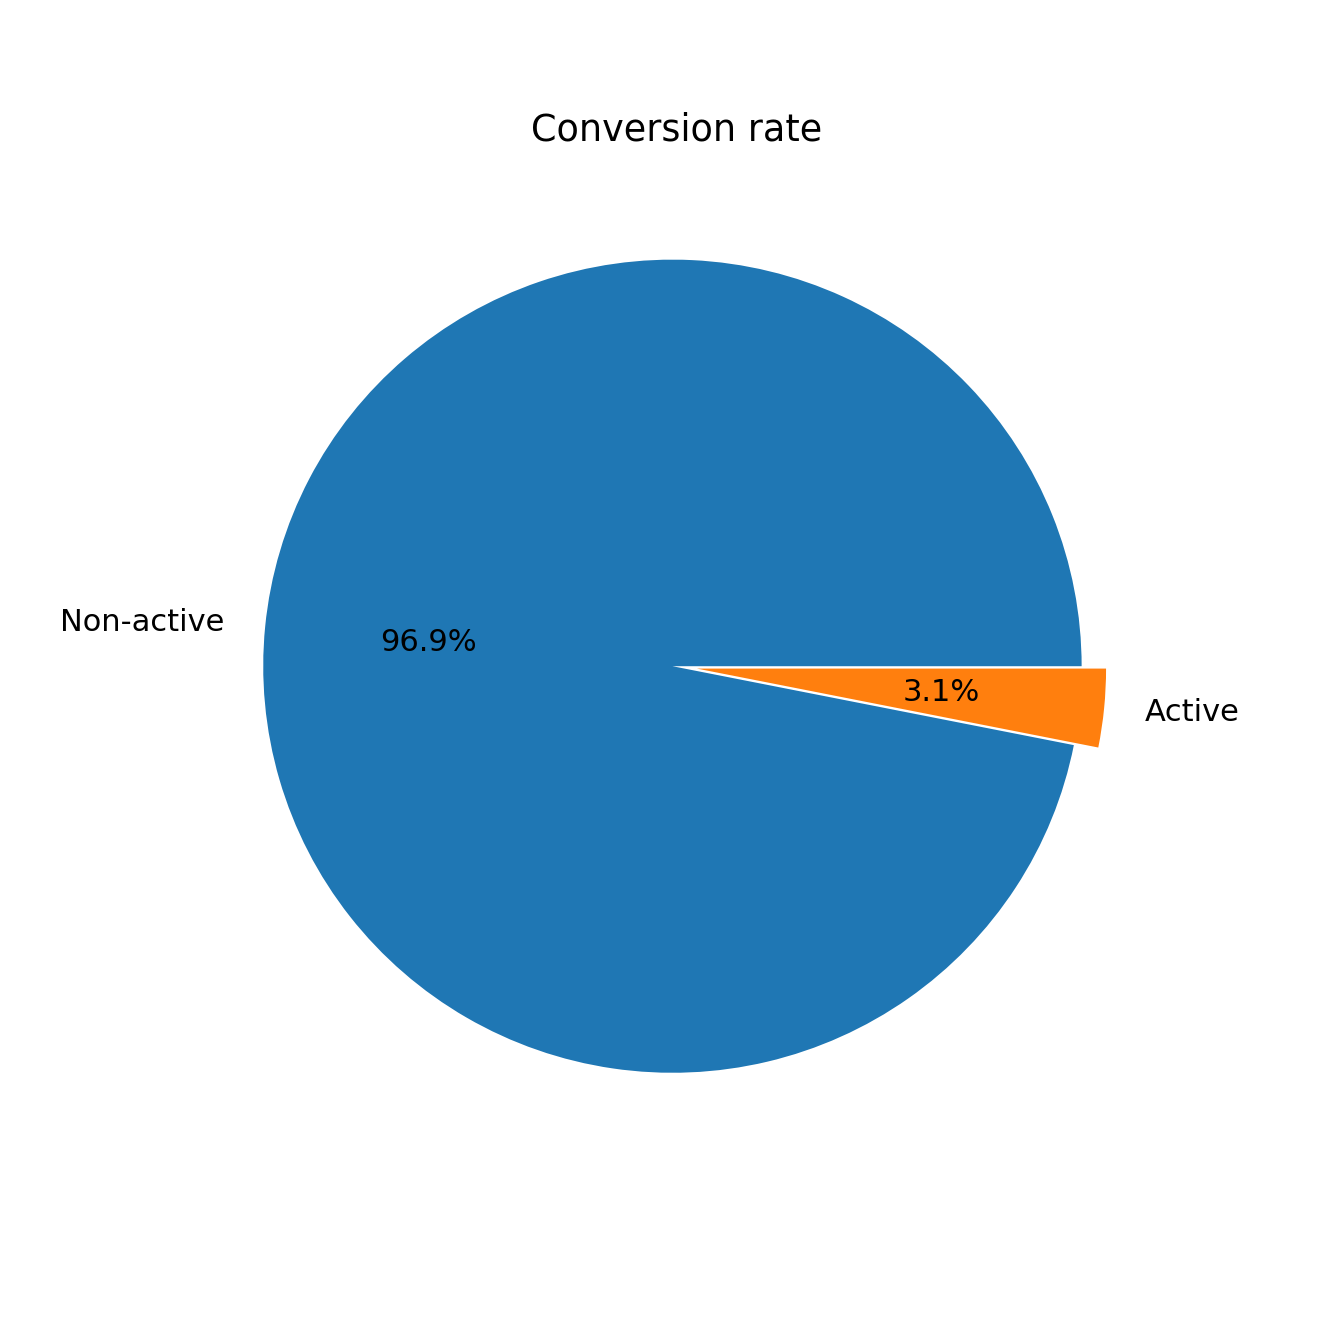

In [10]:
renter_mask = ~df['total_cost'].isnull()
stat_mask = pd.to_datetime(df['created_at'])<pd.to_datetime('2017-03-01')
renter_mask =  (~df['total_cost'].isnull())&stat_mask
plt.figure(figsize=(6,6))
plt.pie([sum(stat_mask)-sum(renter_mask),sum(renter_mask)],
        explode=(0.01,0.05),autopct='%1.1f%%',
       labels=['Non-active',
               'Active'])
plt.title('Conversion rate')

Facebook renter=331
Non-Facebook renter=635


<IPython.core.display.Javascript object>


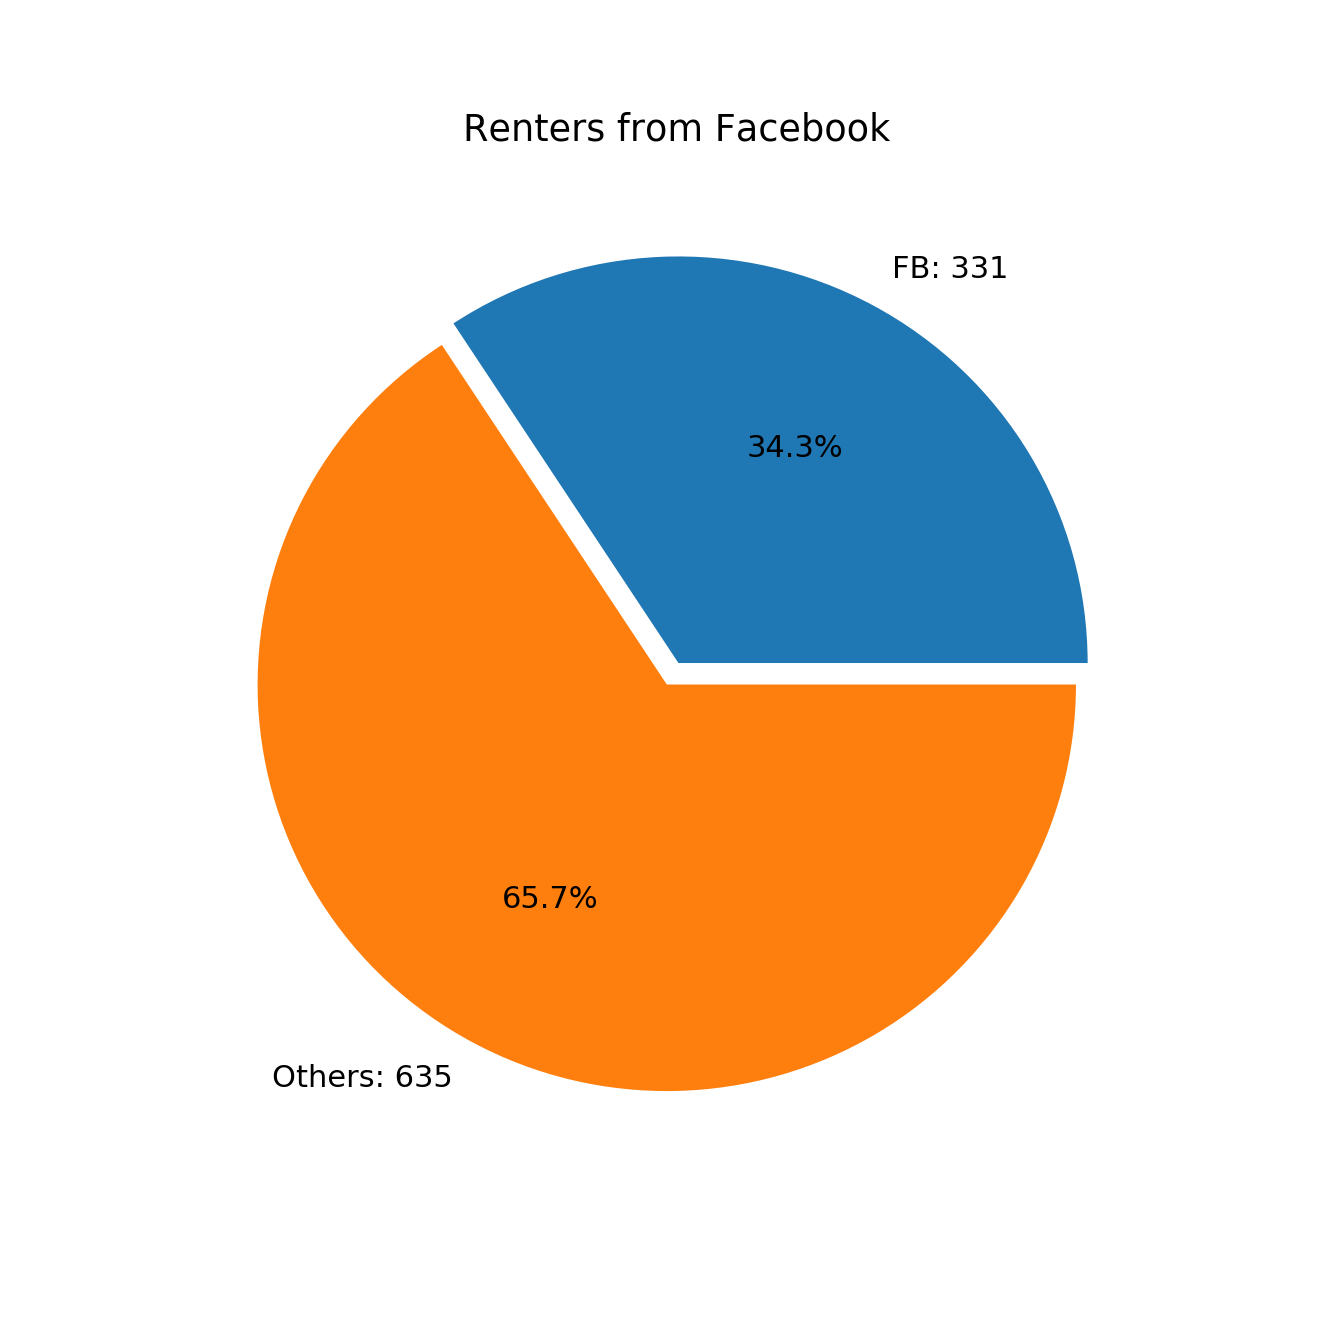

In [4]:
FACEBOOK_SPENT = 37122.97

facebook_renter = df[(df['provider']=='facebook') & (~df['total_cost'].isnull())]
print('Facebook renter={}'.format(len(facebook_renter)))

nonfacebook_renter = df[(df['provider']!='facebook') & (~df['total_cost'].isnull())]
print('Non-Facebook renter={}'.format(len(nonfacebook_renter)))

plt.figure(figsize=(6,6))
plt.pie([len(facebook_renter),len(nonfacebook_renter)],
        explode=(0.01,0.05),autopct='%1.1f%%',
       labels=['FB: {}'.format(len(facebook_renter)),
               'Others: {}'.format(len(nonfacebook_renter))])
plt.title('Renters from Facebook')

CAC, LTV for Facebook users.
CAC, LTV for all users.

Returning rate of users, and LTV for them.


In [5]:
# CAC for users
CAC = FACEBOOK_SPENT/len(df)
CAC_fb = FACEBOOK_SPENT/len(facebook_user)

# CAC for renters
rCAC = FACEBOOK_SPENT/len(facebook_renter)
rCAC_fb = FACEBOOK_SPENT/(len(facebook_renter)+len(nonfacebook_renter))



print("The Facebook CAC for getting registered users is {0:.2f}.".
      format( CAC_fb ))
print("The average CAC for getting registered users is {0:.2f}.".
      format( CAC ))
print("The Facebook CAC for getting renter is {0:.2f}.".
      format( rCAC ))
print("The average CAC for getting renter is {0:.2f}.".
      format( rCAC_fb ))

The Facebook CAC for getting registered users is 2.56.
The average CAC for getting registered users is 1.33.
The Facebook CAC for getting renter is 112.15.
The average CAC for getting renter is 38.43.


In [6]:
last_day = pd.to_datetime('2017-09-11')
dates = pd.to_datetime(df['created_at']).dt.date.sort_values(ascending=False)
life_span = (dates.iloc[0] - dates).dt.days
life_span = life_span.rename('life_span')
df = df.join(life_span)
df.head()

,uid,created_at,current_sign_in_at,provider,total_cost,rented_at,life_span
0,19144,2016-04-10 14:32:00.723492,2016-04-13 23:52:56.998338,facebook,64.0,2016-04-10 15:25:06.616457,515
1,20734,2016-05-19 01:44:27.848269,2016-06-08 17:32:30.137792,None,79.0,2016-06-07 16:47:23.090240,476
2,28404,2017-07-26 00:13:38.340671,2017-09-04 12:55:12.944691,facebook,59.0,2017-07-26 00:20:02.011026,43
3,21516,2016-07-13 13:44:42.945117,2016-08-12 17:40:07.014957,facebook,164.0,2016-07-15 18:11:23.464595,421
4,21313,2016-06-28 14:38:04.082623,2017-01-28 00:36:41.948602,None,249.0,2016-06-29 01:07:31.339633,436


In [7]:
# only consider the customers being with style lend for over 30 days.
stat_mask = df['life_span'] > 30
df.loc[stat_mask, 'avg_exp_per_year'] = df.loc[stat_mask,'total_cost'] / df.loc[stat_mask,'life_span'] *365

In [8]:
renter_mask = (stat_mask) & (~df['total_cost'].isnull())
rLTV = df.loc[renter_mask, 'avg_exp_per_year'].mean()
print("Renter LTV = {0:.2f}".format(rLTV))

LTV = sum(df.loc[renter_mask, 'avg_exp_per_year']) / len(df)
print("Average LTV for registered users = {0:.2f}".format(LTV))

Renter LTV = 177.85
Average LTV for registered users = 6.00


<IPython.core.display.Javascript object>


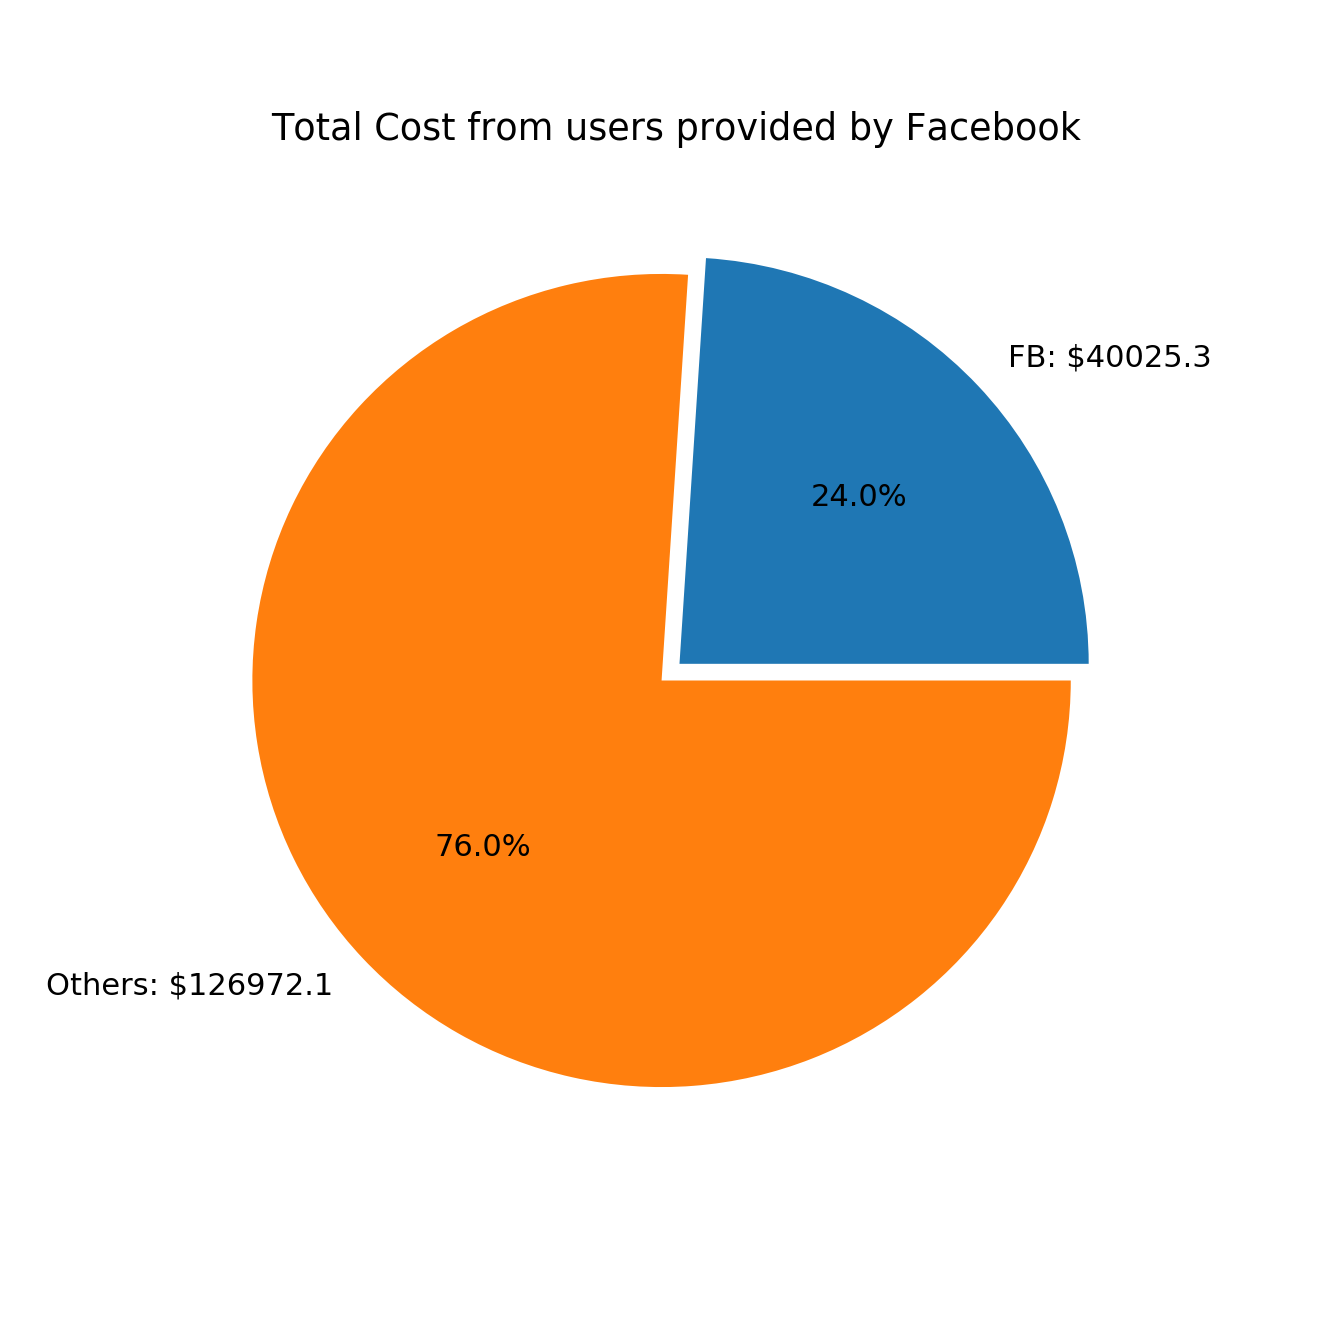

In [9]:
fb_mask = (df.provider=='facebook') & stat_mask
nonfb_mask = (df.provider.isnull()) & stat_mask
tt_fb = df.loc[fb_mask,'avg_exp_per_year'].sum(skipna=True)
tt_nonfb = df.loc[nonfb_mask,'avg_exp_per_year'].sum(skipna=True)

plt.figure(figsize=(6,6))
plt.pie([tt_fb,tt_nonfb],
        explode=(0.01,0.05),autopct='%1.1f%%',
        labels=['FB: ${0:.1f}'.format(tt_fb),
               'Others: ${0:.1f}'.format(tt_nonfb)]
       )
plt.title('Total Cost from users provided by Facebook')

# A table to demonstrate CAC, LTV, and numbers

In [12]:
# define masks
stat_mask = df['life_span'] > 30
fb_mask = df['provider'] == 'facebook'
renter_mask = ~df['total_cost'].isnull()

In [13]:
# LTV for all users
all_LTV = df['avg_exp_per_year'].sum() / len(df)
fb_LTV = df.loc[fb_mask,'avg_exp_per_year'].sum() / sum(fb_mask)
nonfb_LTV = df.loc[~fb_mask,'avg_exp_per_year'].sum() / sum(~fb_mask)


# LTV for all renters
all_rLTV = df.loc[ renter_mask,'avg_exp_per_year'
                 ].sum()/sum( renter_mask )

fb_renter = (fb_mask) & (renter_mask)
fb_rLTV = df.loc[ fb_renter,'avg_exp_per_year'
                ].sum() / sum(fb_renter)

nonfb_renter = (~fb_mask) & (renter_mask)
nonfb_rLTV = df.loc[ nonfb_renter,'avg_exp_per_year'
                   ].sum() / sum(nonfb_renter)



In [14]:
# CAC for all users
all_CAC = FACEBOOK_SPENT / len(df)
fb_CAC = FACEBOOK_SPENT / sum(fb_mask)
nonfb_CAC = 0


# LTV for all renters
all_rCAC = FACEBOOK_SPENT/sum( renter_mask )

fb_renter = (fb_mask) & (renter_mask)
fb_rCAC = FACEBOOK_SPENT / sum(fb_renter)

nonfb_renter = (~fb_mask) & (renter_mask)
nonfb_rCAC = 0


In [15]:
pd.options.display.float_format = '${:,.2f}'.format
user_df = pd.DataFrame(
        {'user':['FB','Non FB','All'],
         'LTV':[fb_LTV, nonfb_LTV, all_LTV],
         'CAC':[fb_CAC, nonfb_CAC, all_CAC]          
        }
        )
user_df = user_df.set_index('user')

renter_df = pd.DataFrame(
        {'renter':['FB','Non FB','All'],
         'LTV':[fb_rLTV, nonfb_rLTV, all_rLTV],
         'CAC':[fb_rCAC, nonfb_rCAC, all_rCAC]          
        }
        )
renter_df = renter_df.set_index('renter')

In [16]:
renter_df.to_csv('../figs/week2/renter_CAC_LTV.csv')
user_df.to_csv('../figs/week2/user_CAC_LTV.csv')

# Recoup graph

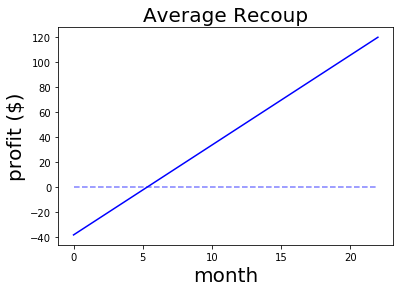

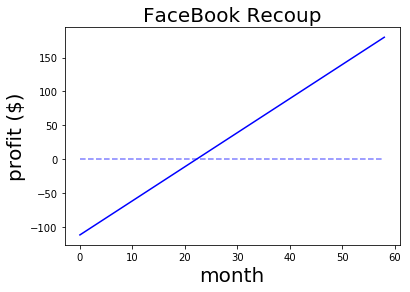

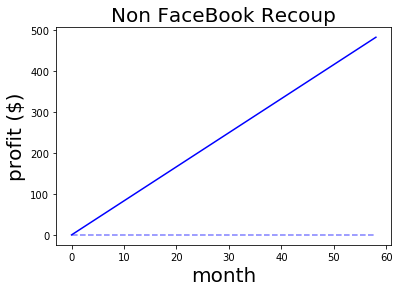

In [17]:
import numpy as np
%matplotlib inline
def recoup_graph(cac, ltv, title,profit_rate=0.5,x = np.arange(0,24,2)):
    """
    cac: cost of acquiring a user
    ltv: lifetime value per year
    """
    y = -cac + ltv/12*x*profit_rate
    plt.plot(x,y,'b-')
    plt.plot(x,np.zeros(np.shape(x)),'b--',alpha=0.5)
    plt.xlabel('month',fontsize=20)
    plt.ylabel('profit ($)',fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
recoup_graph(all_rCAC,all_rLTV,'Average Recoup')
recoup_graph(fb_rCAC,fb_rLTV,'FaceBook Recoup',x=np.arange(0,60,2))
recoup_graph(nonfb_rCAC,nonfb_rLTV,'Non FaceBook Recoup',x=np.arange(0,60,2))